In [2]:
import boto3
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.pyplot as plt

from sache import SpecifiedHookedViT
from vitact.filedataset import FilePathDataset
from vitact.download import download_laion
from top9 import download_sae_checkpoints

In [3]:
locations = [
    (2, "resid"),
    (20, "resid")
]
transformer_name = "laion/CLIP-ViT-L-14-laion2B-s32B-b82K"
device = "cuda"
transformer = SpecifiedHookedViT(locations, transformer_name, device=device)


config.json:   0%|          | 0.00/4.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [4]:
sae_checkpoints = [
's3://sae-activations/log/CLIP-ViT-L-14/2_resid/2_resid_29c579/600023040.pt',
's3://sae-activations/log/CLIP-ViT-L-14/20_resid/20_resid_5998fd/600023040.pt',
]
sae_paths = download_sae_checkpoints(sae_checkpoints, base_dir='cruft')



In [9]:
saes = {}
for location in locations:
    saes[location] = torch.load(sae_paths[location], map_location=device)

/tmp/ipykernel_39745/163290346.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saes[location] = torch.load(sae_paths[location], map_location=device)


In [10]:
def tensor_statistics(tensor):
    μ = tensor.mean()
    σ = tensor.std()
    μ_value = μ.item()
    σ_value = σ.item()
    stats = {
        'mean': μ_value,
        'std': σ_value,
        'median': tensor.median().item(),
        'max': tensor.max().item(),
        'min': tensor.min().item(),
        'L0': (tensor == 0).sum().item(),
        'L1': tensor.abs().sum().item(),
        'variance': tensor.var().item(),
        'sum': tensor.sum().item(),
        'count': tensor.numel(),
        'range': tensor.max().item() - tensor.min().item()
    }
    if σ_value != 0:
        skewness = ((tensor - μ) ** 3).mean() / (σ ** 3)
        kurtosis = ((tensor - μ) ** 4).mean() / (σ ** 4)
        stats['skewness'] = skewness.item()
        stats['kurtosis'] = kurtosis.item()
    else:
        stats['skewness'] = float('nan')
        stats['kurtosis'] = float('nan')
    return stats

In [21]:
all_stats = defaultdict(lambda: defaultdict(list))
for i in range(2):
    random_image = torch.rand((1, 3, 224, 224)).to(device)
    if i == 0:
        random_image = torch.ones_like(random_image) * 255
    else:
        random_image = torch.zeros_like(random_image)
    for location in saes.keys():
        activations = transformer.all_activations(random_image)
        ts = tensor_statistics(activations[location])
        print(location, ts)
        for key, value in ts.items():
            all_stats[location][key].append(value)

(2, 'resid') {'mean': 0.04870568960905075, 'std': 0.18860961496829987, 'median': 0.047067224979400635, 'max': 15.063124656677246, 'min': -3.108478546142578, 'variance': 0.03557358682155609, 'sum': 12817.779296875, 'count': 263168, 'range': 18.171603202819824, 'skewness': 2.852292060852051, 'kurtosis': 211.392822265625}
(20, 'resid') {'mean': 0.1295061558485031, 'std': 0.6362384557723999, 'median': 0.13765616714954376, 'max': 77.14424133300781, 'min': -96.45462799072266, 'variance': 0.40479934215545654, 'sum': 34081.875, 'count': 263168, 'range': 173.59886932373047, 'skewness': -27.002775192260742, 'kurtosis': 7578.552734375}
(2, 'resid') {'mean': 0.0500531941652298, 'std': 0.18944790959358215, 'median': 0.047873079776763916, 'max': 15.133565902709961, 'min': -3.004692792892456, 'variance': 0.03589050844311714, 'sum': 13172.3994140625, 'count': 263168, 'range': 18.138258695602417, 'skewness': 1.990058422088623, 'kurtosis': 208.23709106445312}
(20, 'resid') {'mean': 0.13076551258563995, 

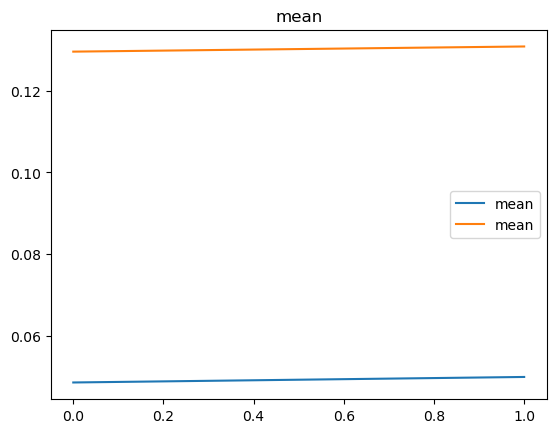

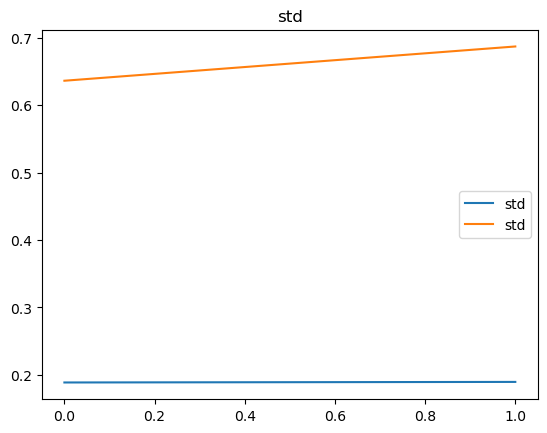

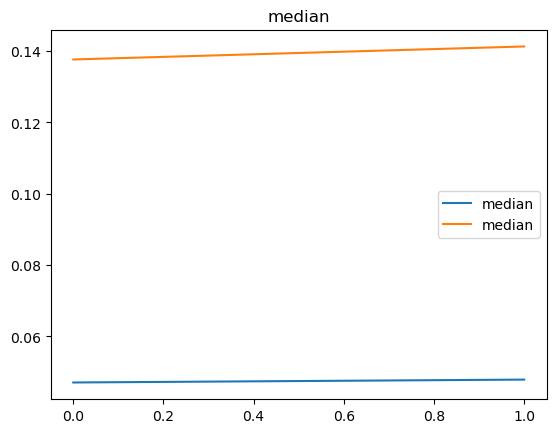

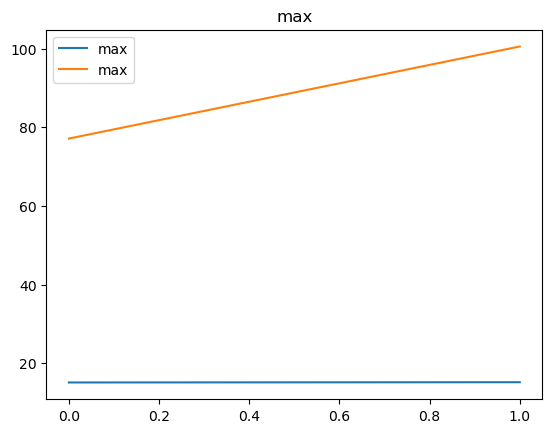

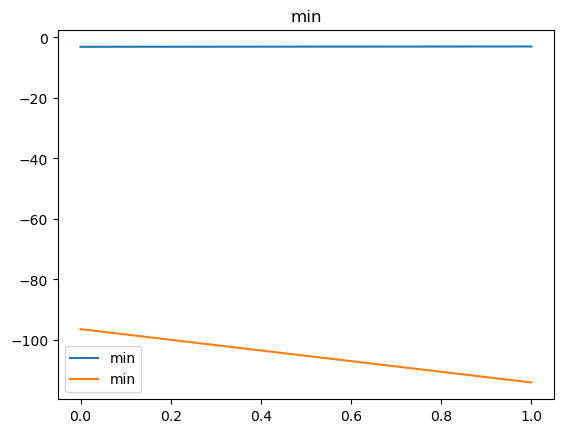

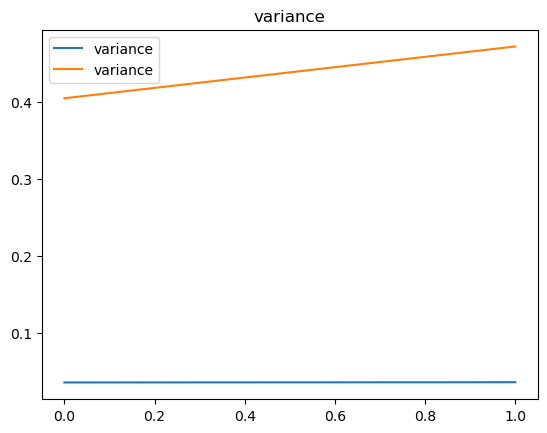

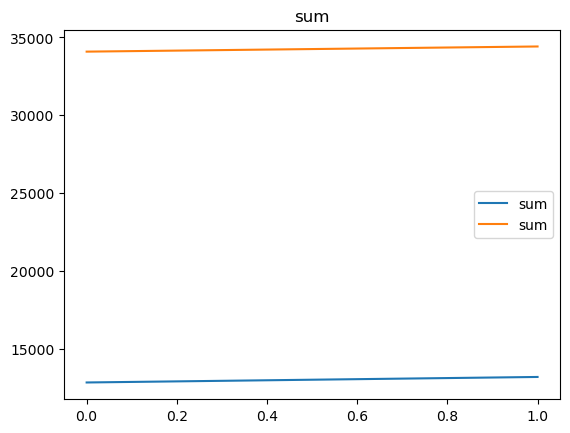

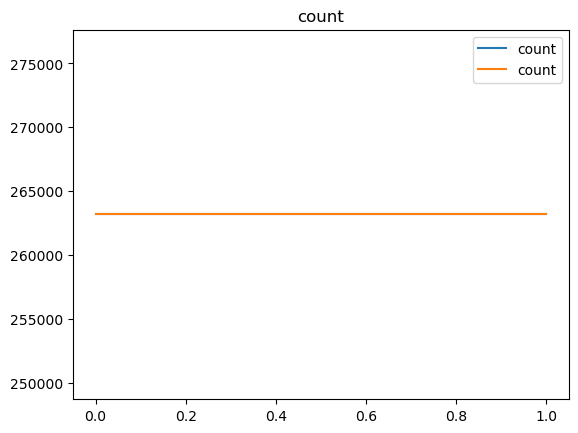

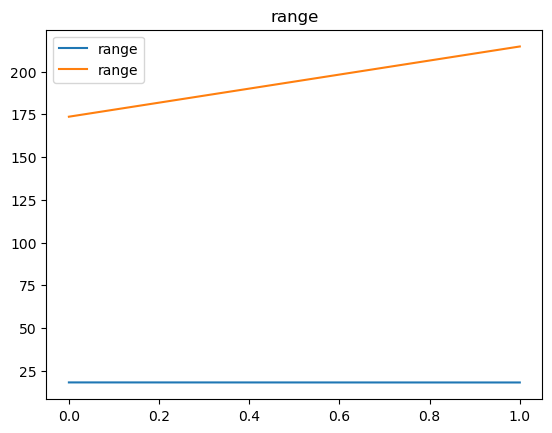

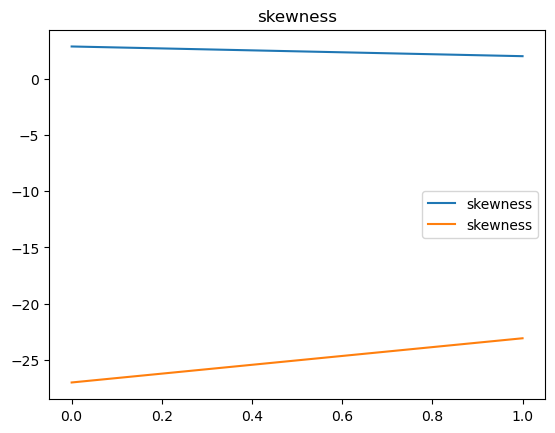

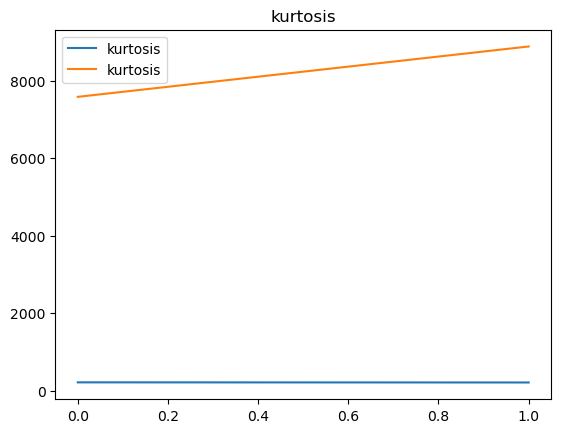

In [22]:
for key in all_stats[(2, 'resid')].keys():
    plt.plot(all_stats[(2, 'resid')][key], label=key)
    plt.plot(all_stats[(20, 'resid')][key], label=key)
    plt.title(key)
    plt.legend()
    plt.show()

In [3]:
laion_img_dir = 'cruft/bench'
ds = FilePathDataset(laion_img_dir)


In [7]:
for path, img in ds:

    print(img.shape, img.dtype)
    break



torch.Size([3, 224, 224]) torch.uint8
